In [ ]:
# importing libaries
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# local runtime space of dataset
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

! kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

# #unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [ ]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.2}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)


## Data generator for training images
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/car_data/car_data/train',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/car_data/car_data/train',
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/car_data/car_data/test',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [ ]:
def build_vgg16_transfer_learning_model(img_height=224,img_width=224,num_classes=196):

    # base model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        input_shape=(img_height, img_width, 3),
        include_top=False) 
    base_model.trainable = False

    # add the top
    input_image = tf.keras.Input(shape=(img_height, img_width, 3))
    x1 = base_model(input_image, training=False)
    x2 = tf.keras.layers.Flatten()(x1)
    
    out = tf.keras.layers.Dense(num_classes,activation = 'softmax')(x2)
    model = tf.keras.Model(inputs = input_image, outputs =out)
  
    #compile and return
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [ ]:
model = build_vgg16_transfer_learning_model()
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 196)               4917444   
Total params: 19,632,132
Trainable params: 4,917,444
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_name = "vgg16_cars.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
batch = 128
num_epochs = 150

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/150
207/207 [==============================] - 172s 673ms/step - loss: 5.5246 - accuracy: 0.0108 - val_loss: 4.9535 - val_accuracy: 0.0498
Epoch 2/150
207/207 [==============================] - 135s 652ms/step - loss: 4.5354 - accuracy: 0.1053 - val_loss: 4.6210 - val_accuracy: 0.0834
Epoch 3/150
207/207 [==============================] - 135s 650ms/step - loss: 3.9932 - accuracy: 0.2014 - val_loss: 4.3936 - val_accuracy: 0.1197
Epoch 4/150
207/207 [==============================] - 135s 650ms/step - loss: 3.5752 - accuracy: 0.2850 - val_loss: 4.2018 - val_accuracy: 0.1339
Epoch 5/150
207/207 [==============================] - 132s 636ms/step - loss: 3.2271 - accuracy: 0.3759 - val_loss: 4.0429 - val_accuracy: 0.1669
Epoch 6/150
207/207 [==============================] - 133s 643ms/step - loss: 3.0258 - accuracy: 0.4313 - val_loss: 3.9532 - val_accuracy: 0.1966
Epoch 7/150
207/207 [==============================] - 134s 646ms/step - loss: 2.8873 - accuracy: 0.4661 - val_loss: 3

In [ ]:
## finetune model
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224,224,3),
    include_top=False) 
base_model.trainable = True
input_image = tf.keras.Input(shape=(224,224,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(196,activation = 'softmax')(x2)
model = tf.keras.Model(input_image, out)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights('/content/gdrive/MyDrive/Kaggle/vgg16_cars.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               4917444   
Total params: 19,632,132
Trainable params: 19,632,132
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch = 128
num_epochs = 100
history_2 = model.fit(train_generator,
          validation_data = val_generator,
          epochs=num_epochs,
          verbose=1,
          batch_size=batch,
          callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
207/207 [==============================] - 134s 637ms/step - loss: 1.7387 - accuracy: 0.6643 - val_loss: 3.5073 - val_accuracy: 0.2697
Epoch 2/100
207/207 [==============================] - 133s 641ms/step - loss: 1.2307 - accuracy: 0.6995 - val_loss: 3.4824 - val_accuracy: 0.2878
Epoch 3/100
207/207 [==============================] - 133s 644ms/step - loss: 1.1457 - accuracy: 0.7173 - val_loss: 3.4983 - val_accuracy: 0.2827
Epoch 4/100
207/207 [==============================] - 132s 637ms/step - loss: 1.0519 - accuracy: 0.7302 - val_loss: 3.4595 - val_accuracy: 0.3008
Epoch 5/100
207/207 [==============================] - 132s 635ms/step - loss: 0.9604 - accuracy: 0.7598 - val_loss: 3.5058 - val_accuracy: 0.3047
Epoch 6/100
207/207 [==============================] - 132s 637ms/step - loss: 0.9536 - accuracy: 0.7459 - val_loss: 3.4443 - val_accuracy: 0.3034
Epoch 7/100
207/207 [==============================] - 132s 638ms/step - loss: 0.9178 - accuracy: 0.7676 - val_loss: 3

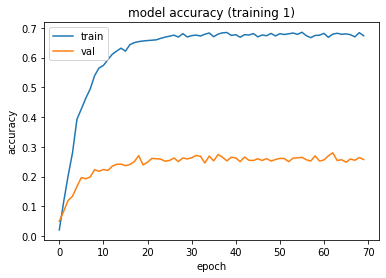

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (training 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/gdrive/MyDrive/Kaggle/vgg16_cars.h5')
metrics = model.evaluate(test_generator)

252/252 [==============================] - 69s 276ms/step - loss: 3.2649 - accuracy: 0.3623


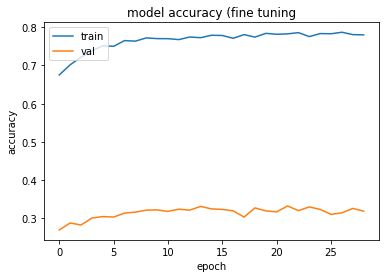

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy (fine tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

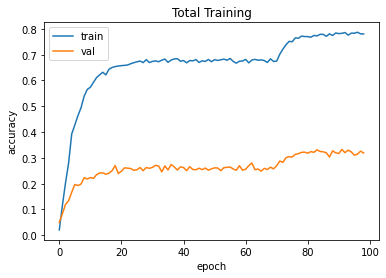

In [ ]:
acc_total = np.zeros(len(history.history['accuracy']) + len(history_2.history['accuracy']))
val_total = np.zeros(len(history.history['val_accuracy']) + len(history_2.history['val_accuracy']))

for i in range(len(history.history['accuracy'])):
  acc_total[i] = history.history['accuracy'][i]
  val_total[i] = history.history['val_accuracy'][i]
  
for j in range(len(history_2.history['accuracy'])):
  acc_total[j+len(history.history['accuracy'])] = history_2.history['accuracy'][j]
  val_total[j+len(history.history['val_accuracy'])] = history_2.history['val_accuracy'][j]



plt.plot(acc_total)
plt.plot(val_total)
plt.title('Total Training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()  

In [ ]:
max(history_2.history['val_accuracy'])

0.3324708938598633

In [ ]:
max(history_2.history['accuracy'])

0.7869051098823547